In [1]:
from plot import (
    read_results, 
    combine_results,
    get_experimental_data,
    get_absolute_dGs
)
from functions import (
    read_protocol
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (
    spearmanr,
    pearsonr
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    root_mean_squared_error
)

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [2]:
def compute_statistic(experimental_samples, calculated_samples, statistic):
    if statistic.lower() == "rmse":
        statistic = root_mean_squared_error(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "mae":
        statistic = mean_absolute_error(y_true=experimental_samples, y_pred=calculated_samples)
    
    elif statistic.lower() == "r2":
        statistic = r2_score(y_true=experimental_samples, y_pred=calculated_samples)

    elif statistic.lower() == "pearson":
        statistic = pearsonr(x=experimental_samples, y=calculated_samples)[0]
    
    elif statistic.lower() == "rho":
        statistic = spearmanr(a=experimental_samples, b=calculated_samples)[0]
    return statistic

def bootstrap(experimental, calculated,  statistic, n_bootstrap_samples=1000, ci=0.95):
    sample_size = len(experimental)
    assert sample_size == len(calculated), f"Calculated ({len(calculated)}) and experimental ({sample_size}) lengths do not match"
    
    bootstrapped_data = np.zeros(
        [n_bootstrap_samples], np.float64
    ) 
    for i in range(n_bootstrap_samples):
        if i==0:
            experimental_samples = experimental
            calculated_samples = calculated
        else:
            bootstrap_sample = np.random.choice(range(sample_size), size = sample_size, replace=True)
            experimental_samples = [experimental[i] for i in bootstrap_sample]
            calculated_samples = [calculated[i] for i in bootstrap_sample]
        bootstrapped_data[i] = compute_statistic(experimental_samples, 
                                                 calculated_samples,
                                                 statistic)
    mean = np.mean(bootstrapped_data)
    lower_fraction = ((1 - ci)/2.0) * 100

    upper_fraction = 100 - lower_fraction

    lower_bound = np.percentile(bootstrapped_data, lower_fraction)
    upper_bound = np.percentile(bootstrapped_data, upper_fraction)
    return bootstrapped_data, mean, lower_bound, upper_bound

def plot_hist(data, n_bins=100):
    plt.hist(data, bins=n_bins, edgecolor="black")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Model 1

In [3]:
working_directory = "/home/jguven/projects/alchemistry/model_1_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"

In [4]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-0.571977,0.143196
1,ligand_6,-8.354581,0.072703,0.353213,0.073940
2,ligand_8,-7.524502,0.018065,-0.969830,0.083567
3,ligand_9,-8.127579,0.079488,-0.457843,0.070890
4,ligand_10,-7.524502,0.005420,-1.082885,0.085610
5,ligand_11,-7.129619,0.003726,-0.330954,0.079446
6,ligand_12,-7.035065,0.001590,1.713554,0.267394
7,ligand_13,-7.506705,0.005260,0.011349,0.076265
8,ligand_15,-6.202678,0.062961,2.906903,0.110250
9,ligand_16,-8.923058,0.028299,-1.571528,0.073917


In [5]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
experimental_values = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")

### Pearson r

/home/jguven/projects/metalloenzymes/meze/functions.py:418: RuntimeWarning: Mean of empty slice
  return np.nanmean(values, axis=1)
/home/jguven/projects/metalloenzymes/meze/plot.py:262: UserWarning: Some transformations contained NaNs. Please check /home/jguven/projects/alchemistry/model_1_vim2/outputs///SOMD_results.csv for details.
  warnings.warn(f"Some transformations contained NaNs. Please check {results_file} for details.")
/home/jguven/Software/miniconda3/envs/obss-d/lib/python3.9/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/jguven/projects/metalloenzymes/meze/functions.py:418: RuntimeWarning: Mean of empty slice
  return np.nanmean(values, axis=1)
/home/jguven/projects/metalloenzymes/meze/plot.py:262: UserWarning: Some transformations contained NaNs. Please check /home/jguven/projects/alchemistry/model_0_vim2/outputs///SOMD_results.csv for details.
  warnings.warn(f"Som

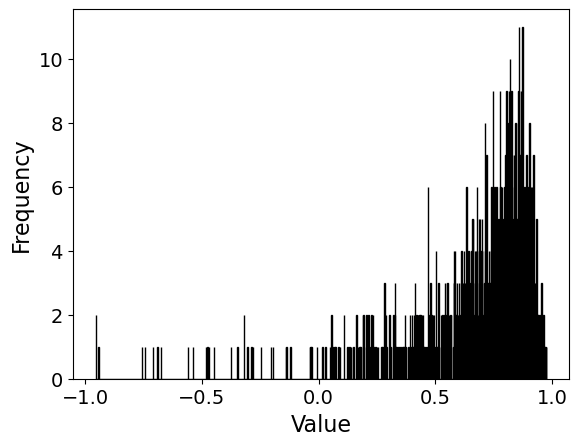

mean: 0.664336783501702
lower: -0.1397020244938966
upper: 0.936848292328064


In [6]:
pearson_distr, pearson, pearson_low, pearson_high = bootstrap(experimental=experimental_values,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

## Spearman

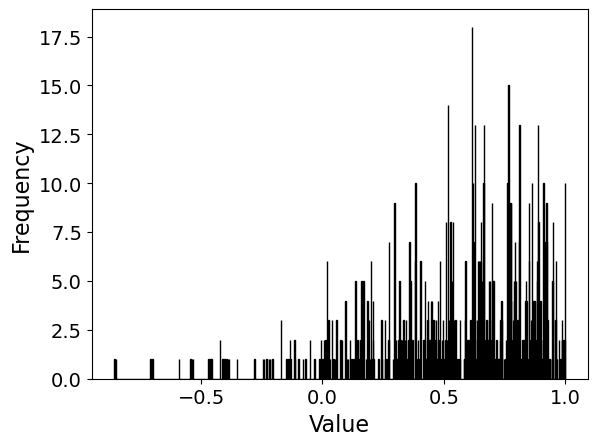

mean: 0.5670214457264321
lower: -0.23099372067457905
upper: 0.9627871283071423


In [7]:
rho_distr, rho, rho_low, rho_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## MAE

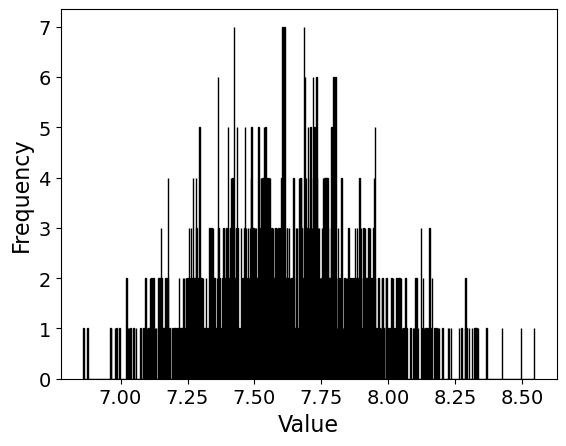

mean: 7.619390071524607
lower: 7.1109953608026055
upper: 8.16237446254835


In [8]:
mae_distr, mae, mae_low, mae_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## RMSE


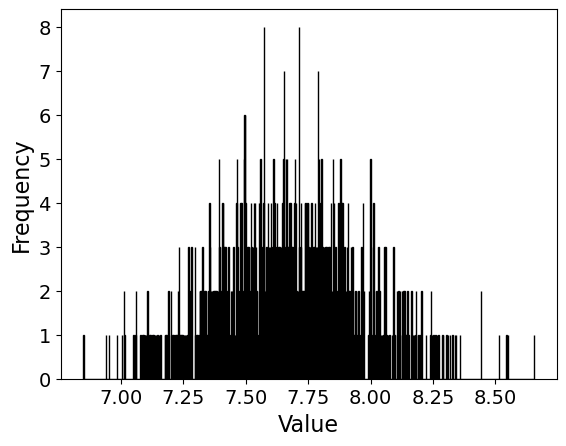

mean: 7.662839178082392
lower: 7.125339533876374
upper: 8.223194264581391


In [9]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")

# Model 0

In [10]:
working_directory = "/home/jguven/projects/alchemistry/model_0_vim2/"
protocol_file = f"{working_directory}/afe/protocol.dat"
experimental_file = f"{working_directory}/afe/experimental_K_i.csv"


In [11]:
protocol = read_protocol(protocol_file)
transformations, free_energies, errors = read_results(protocol) 
results = combine_results(protocol, transformations, free_energies, errors)
absolute_dataframe = get_absolute_dGs(experimental_file=experimental_file,
                                      calculated_dataframe=results,
                                      protocol=protocol)
absolute_dataframe

,label,exp_dG,exp_err,calc_dG,calc_err
0,ligand_2,-7.793958,0.056777,-2.703135,0.204047
1,ligand_6,-8.354581,0.072703,0.778795,0.114841
2,ligand_8,-7.524502,0.018065,1.063872,0.130315
3,ligand_9,-8.127579,0.079488,-0.691855,0.107380
4,ligand_10,-7.524502,0.005420,0.911465,0.124754
5,ligand_11,-7.129619,0.003726,-0.304710,0.329641
6,ligand_12,-7.035065,0.001590,0.278411,0.230485
7,ligand_13,-7.506705,0.005260,0.663411,0.125475
8,ligand_15,-6.202678,0.062961,1.324241,0.181865
9,ligand_16,-8.923058,0.028299,-1.320494,0.120640


In [12]:
get_column = lambda column: absolute_dataframe[column].to_numpy()
experimental_values = get_column("exp_dG")
experimental_errors = get_column("exp_err")
calculated_values = get_column("calc_dG")
calculated_errors = get_column("calc_err")


### Pearson R

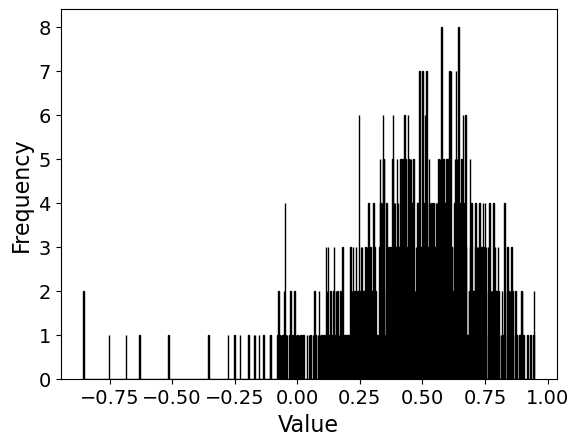

mean: 0.47381072886902026
lower: -0.05284132403065114
upper: 0.8547106359058108


In [13]:
pearson_distr, pearson, pearson_low, pearson_high = bootstrap(experimental=experimental_values,
                                                              calculated=calculated_values,
                                                              statistic="pearson",
                                                              n_bootstrap_samples=1000)
plot_hist(pearson_distr, n_bins=1000)
print(f"mean: {pearson}")
print(f"lower: {pearson_low}")
print(f"upper: {pearson_high}")

## Spearman $\rho$

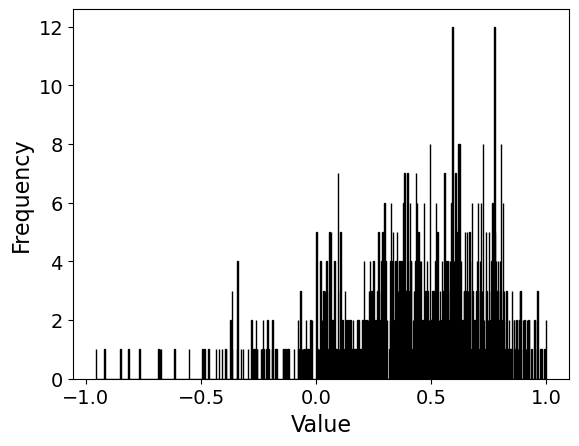

mean: 0.43253000696155774
lower: -0.3428922678455761
upper: 0.89873417721519


In [14]:
rho_distr, rho, rho_low, rho_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rho",
                                              n_bootstrap_samples=1000)
plot_hist(rho_distr, n_bins=1000)
print(f"mean: {rho}")
print(f"lower: {rho_low}")
print(f"upper: {rho_high}")

## Coefficient of determination (R2 score)

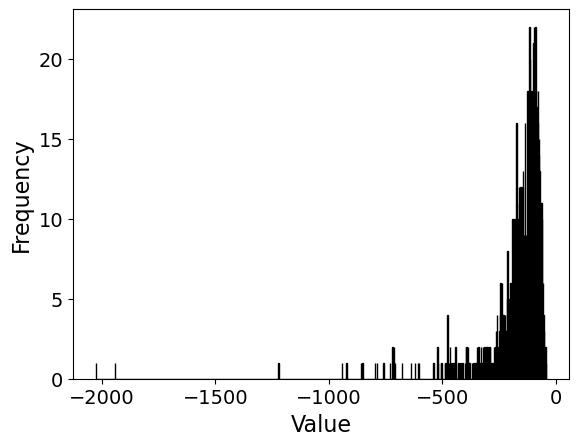

mean: -167.71722427848783
lower: -507.85753121618706
upper: -59.63840803568427


In [15]:
r2_distr, r2, r2_low, r2_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="r2",
                                              n_bootstrap_samples=1000)
plot_hist(r2_distr, n_bins=1000)
print(f"mean: {r2}")
print(f"lower: {r2_low}")
print(f"upper: {r2_high}")

## Mean absolute error

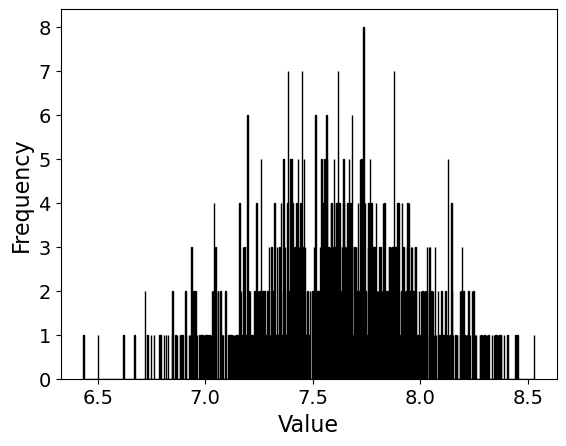

mean: 7.620563987276599
lower: 6.9243167890079285
upper: 8.250721524721945


In [16]:
mae_distr, mae, mae_low, mae_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="mae",
                                              n_bootstrap_samples=1000)
plot_hist(mae_distr, n_bins=1000)
print(f"mean: {mae}")
print(f"lower: {mae_low}")
print(f"upper: {mae_high}")

## Root mean squared error

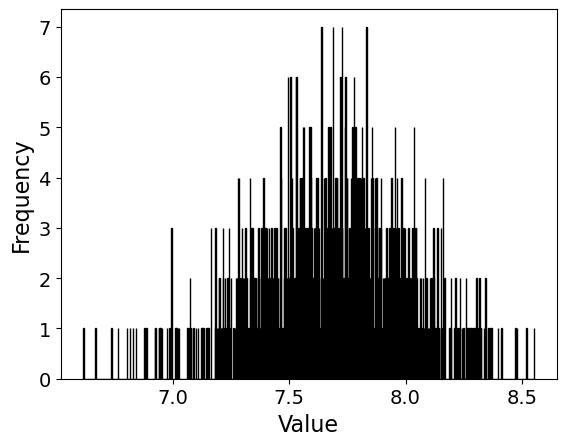

mean: 7.68287457411725
lower: 7.021588464987876
upper: 8.271858665992882


In [17]:
rmse_distr, rmse, rmse_low, rmse_high = bootstrap(experimental=experimental_values,
                                              calculated=calculated_values,
                                              statistic="rmse",
                                              n_bootstrap_samples=1000)
plot_hist(rmse_distr, n_bins=1000)
print(f"mean: {rmse}")
print(f"lower: {rmse_low}")
print(f"upper: {rmse_high}")